In [1702]:
# import torch
# import torchvision
import cv2
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects, binary_opening, disk
from scipy.ndimage import binary_fill_holes, zoom, distance_transform_edt, label

# Mask

#### Follow these steps
- ##### 1. For each slice x such that 0 <= x < 90, threshold(240) and min_size(800)
- ##### 2. For each slice x such that 90 <= x < 94, remove blobs(top 1 feature), threshold(160) and min_size(800)
- ##### 3. For each slice x such that 94 <= x < 102, threshold(180) and min_size(800)
- ##### 4. For slice x such that x == 103, threshold(280) and min_size(800)
- ##### 5. For each slice x such that 104 <= x < 108, threshold(130) and min_size(60)
- ##### 6. For each slice x such that 108 <= x < 130, threshold(180) and min_size(1200)
- ##### 7. For each slice x such that x >= 130, threshold(240) and min_size(800)

In [1703]:
# Segmentation
volume = nib.load("../datasets/3702_left_knee.nii.gz")
data = volume.get_fdata()

In [1704]:
binary_mask = np.zeros_like(data)

In [1708]:
def mask_slice(i, threshold_value=240, min_size=800, zoom_factor=4, sigma=2):
    """
    Create a binary mask for a specific slice index in the CT volume.

    Parameters:
        i (int): Slice index to process.
        threshold_value (int): Intensity threshold for binarization.
        sigma (float): Gaussian blur sigma value.
        zoom_factor (int or float): Factor to zoom in before processing.

    Returns:
        np.ndarray: A binary mask for the given slice.
    """
    # Extract the slice
    slice = data[:, :, i]

    # Upsample to improve resolution for thresholding
    zoom_in = zoom(slice, (zoom_factor, zoom_factor), order=0)

    # Apply Gaussian blur to reduce noise
    blurred = gaussian(zoom_in, sigma=sigma)

    # Thresholding to create binary mask
    _, thresh = cv2.threshold(blurred, threshold_value, 255, cv2.THRESH_BINARY)

    # Downsample to original shape
    zoom_out = zoom(thresh, (1/zoom_factor, 1/zoom_factor), order=0)

    # Fill internal holes
    filled_mask = binary_fill_holes(zoom_out)

    # Optional: Apply morphological opening to remove small artifacts
    opening = binary_opening(filled_mask, disk(1), mode="ignore")

    # Remove small objects to clean up the mask
    clean_mask = remove_small_objects(opening.astype(bool), min_size=min_size)

    return clean_mask


In [ ]:
def remove_blobs(clean_mask):

    # Distance transform and peak detection
    distance = distance_transform_edt(clean_mask)
    coords = peak_local_max(distance, labels=clean_mask, footprint=np.ones((10, 10)), min_distance=25)
    
    # Label the peaks
    markers = np.zeros_like(distance, dtype=bool)
    markers[tuple(coords.T)] = True
    markers, _ = label(markers)

    # Watershed to separate loosely connected regions
    labels_ws = watershed(-distance, markers, mask=clean_mask)

    output_mask = np.zeros_like(clean_mask, dtype=bool)
    for region in sorted(regionprops(labels_ws), key=lambda r: r.area, reverse=True)[:1]:
        output_mask[labels_ws == region.label] = True

    return output_mask
    

In [1723]:
# Define the range of slices to process
def process_slices(start, end, threshold_value, min_size):

    for i in range(start, end):
        
        # Generate mask from the slice
        clean_mask = mask_slice(i, threshold_value, min_size)

        output_mask = remove_blobs(clean_mask)

        # Store the mask in the binary volume
        binary_mask[:, :, i] = output_mask.astype(np.uint8)


In [1724]:
process_slices(90, 94, 160, 800)

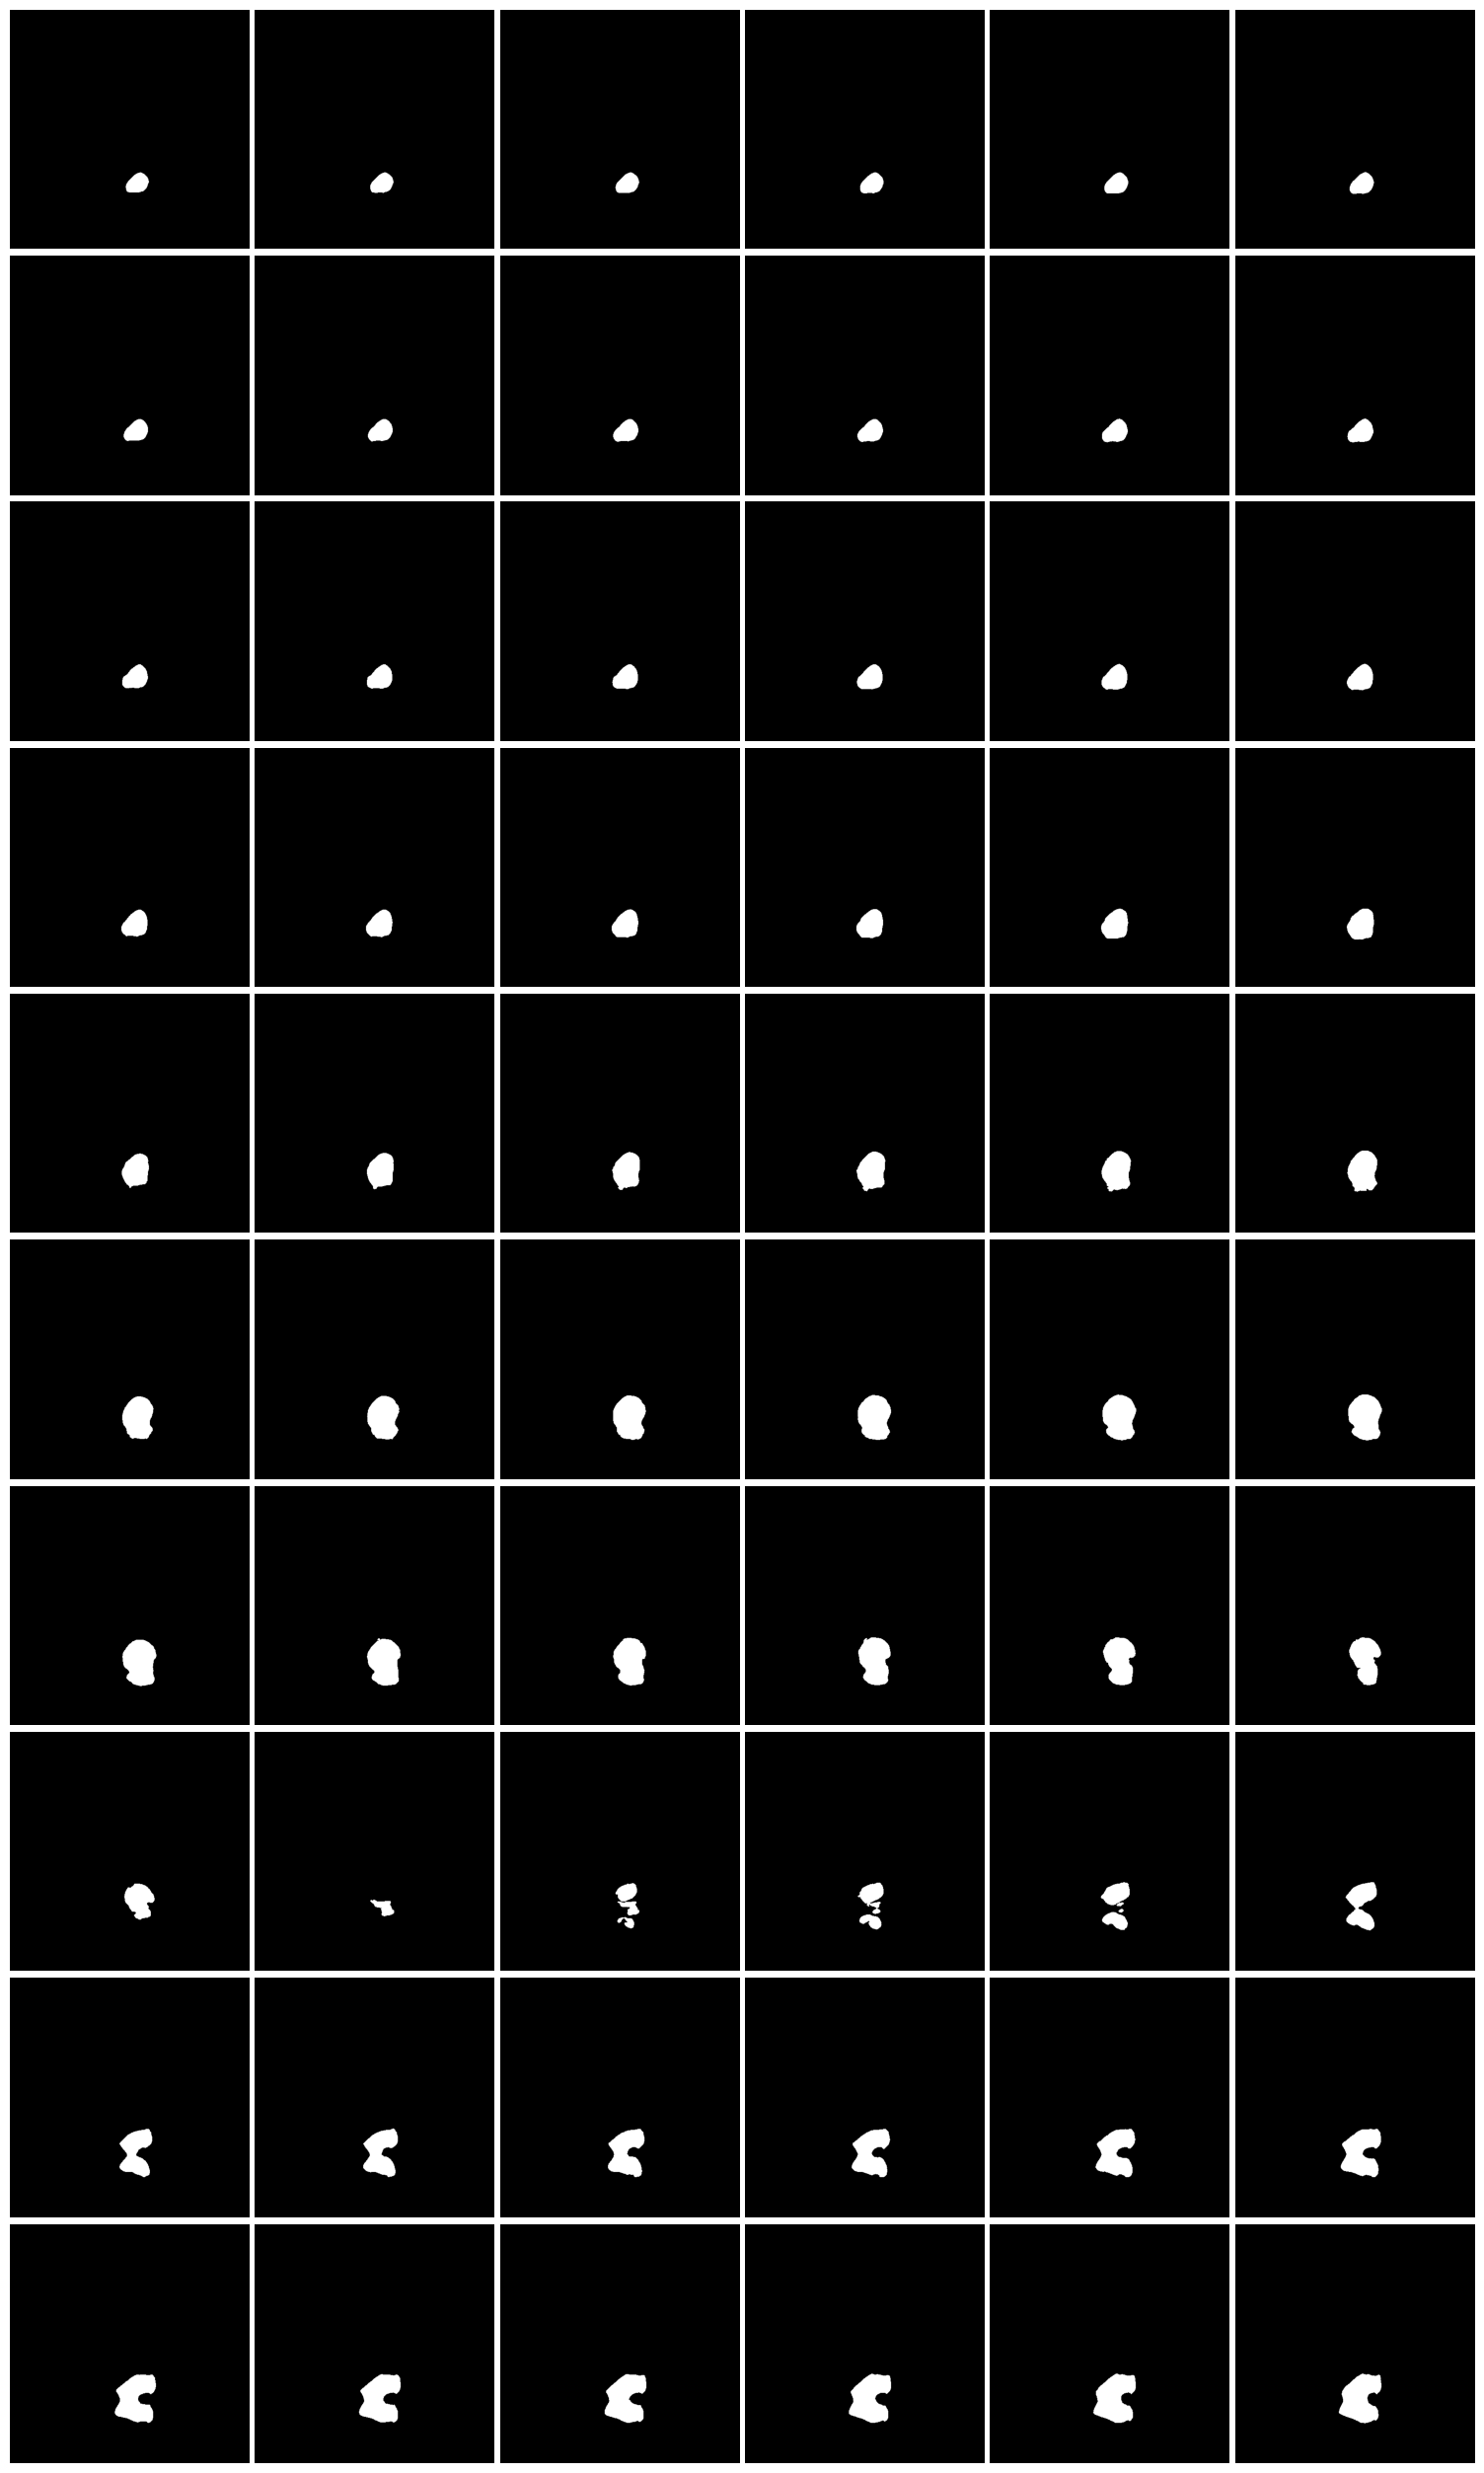

In [1728]:
fig, axes = plt.subplots(10, 6, figsize=(15, 25))
for i, ax in enumerate(axes.flat):
    ax.imshow(binary_mask[:, :, 60+i], cmap="gray")
    ax.axis("off")
plt.tight_layout(pad=0.5)
plt.show()

# Segmentation

In [1730]:
ct_volume = nib.load("../datasets/3702_left_knee_mask_final.nii.gz")
ct_data = ct_volume.get_fdata()

In [1731]:
from scipy.ndimage import distance_transform_edt, label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

def watershed_segmentation(volume):
    """
    Applies 3D watershed segmentation to a binary volume using distance transform and local maxima.

    Parameters:
    - volume (np.ndarray): A 3D binary mask volume.

    Returns:
    - labels (np.ndarray): A 3D array of watershed-labeled regions.
    """
    # Ensure input is boolean
    binary_volume = volume.astype(bool)
    
    # Compute the Euclidean distance transform
    distance = distance_transform_edt(binary_volume)
    
    # Detect local maxima to serve as markers
    coordinates = peak_local_max(
        distance,
        footprint=np.ones((100, 100, 100)),
        labels=binary_volume,
        exclude_border=False
    )
    
    # Create marker image
    marker_mask = np.zeros(distance.shape, dtype=bool)
    marker_mask[tuple(coordinates.T)] = True
    
    # Label the markers
    markers, _ = label(marker_mask)
    
    # Apply the watershed algorithm
    labels = watershed(-distance, markers, mask=binary_volume)
    
    return labels


In [170]:
volume_3d = np.stack(ct_data, axis=0)

In [171]:
labels = watershed_segmentation(volume_3d)

In [ ]:
import mayavi.mlab as mlab

mlab.contour3d(volume_3d, color=(1,1,1))
mlab.show()

In [183]:
volume_rgb = np.zeros((512, 512, 216, 3), dtype=np.uint8)

volume_rgb[labels == 0] = [128, 128, 128]
volume_rgb[labels == 1] = [0, 255, 0]
volume_rgb[labels == 2] = [255, 0, 0]

In [ ]:
mlab.contour3d((labels == 1).astype(np.uint8), color=(0, 1, 0), opacity=0.5)
mlab.show()

In [184]:
volume_rgb = volume_rgb.astype(np.float32) / 255.0

In [185]:
import torch
tensor_3d = torch.from_numpy(volume_rgb).permute(3, 2, 0, 1)

In [186]:
tensor_3d.shape

torch.Size([3, 216, 512, 512])

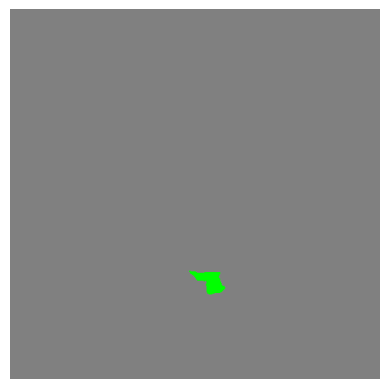

In [190]:
rgb_slice = tensor_3d[:, 103, :, :]
rgb_slice_np = rgb_slice.permute(1, 2, 0).numpy()
plt.imshow(rgb_slice_np)
plt.axis("off")
plt.show()

In [64]:
import torch
from torch import nn
import torchvision.models as models
model_2d = models.densenet121(pretrained=True)

d:\inside-cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\inside-cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
model_2d.classifier = nn.Identity()

In [66]:
def inflate_conv2d(conv2d):

    in_channels = conv2d.in_channels
    out_channels = conv2d.out_channels

    k = conv2d.kernel_size[0]
    kernel_size_3d = (k, k, k)

    s = conv2d.stride[0]
    stride_3d = (s, s, s)
    
    if hasattr(conv2d, "padding") and isinstance(conv2d.padding, tuple):
        p = conv2d.padding[0]
        padding_3d = (p, p, p)
    else:
        padding_3d = 0

    conv3d = nn.Conv3d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size_3d,
        stride=stride_3d,
        padding=padding_3d,
        bias=conv2d.bias
    )

    with torch.no_grad():
        weight_2d = conv2d.weight.data
        weight_3d = weight_2d.unsqueeze(2).repeat(1, 1, k, 1, 1)/k
        conv3d.weight.data.copy_(weight_3d)
        if conv2d.bias is not None:
            conv3d.bias.data.copy_(conv2d.bias.data)
    return conv3d


In [67]:
conv0 = nn.Conv2d(3, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
conv3d = inflate_conv2d(conv0)

In [68]:
def inflate_batchnorm2d(bn2d):
    bn3d = nn.BatchNorm3d(
        bn2d.num_features,
        eps=bn2d.eps,
        momentum=bn2d.momentum,
        affine=bn2d.affine,
        track_running_stats=bn2d.track_running_stats
    )

    if bn2d.affine:
        with torch.no_grad():
            bn3d.weight.data.copy_(bn2d.weight.data)
            bn3d.bias.data.copy_(bn2d.bias.data)
    
    if bn2d.track_running_stats:
        bn3d.running_mean.data.copy_(bn2d.running_mean.data)
        bn3d.running_var.copy_(bn2d.running_var.data)

    return bn3d

In [69]:
norm0 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
norm3d = inflate_batchnorm2d(norm0)

In [70]:
def inflate_maxpool2d(maxpool2d):

    maxpool3d = nn.MaxPool3d(
        kernel_size=maxpool2d.kernel_size,
        stride=maxpool2d.stride,
        padding=maxpool2d.padding,
        dilation=maxpool2d.dilation,
        ceil_mode=maxpool2d.ceil_mode
    )

    return maxpool3d


In [71]:
pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
inflate_maxpool2d(pool0)

MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

In [72]:
def inflate_avgpool2d(avgpool2d):
        
    avgpool3d = nn.AvgPool3d(
        kernel_size=avgpool2d.kernel_size,
        stride=avgpool2d.stride,
        padding=avgpool2d.padding
    )

    return avgpool3d


In [73]:
conv1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
inflate_avgpool2d(conv1)

AvgPool3d(kernel_size=2, stride=2, padding=0)

In [74]:
def convert_densenet121(model_2d):
    for name, module in model_2d.named_children():
        # Recursively go inside children
        convert_densenet121(module)

        # Convert Conv2d → Conv3d
        if isinstance(module, nn.Conv2d):
            new_layer = inflate_conv2d(module)
            setattr(model_2d, name, new_layer)

        # Convert BatchNorm2d → BatchNorm3d
        elif isinstance(module, nn.BatchNorm2d):
            new_layer = inflate_batchnorm2d(module)
            setattr(model_2d, name, new_layer)

        # Convert MaxPool2d → MaxPool3d
        elif isinstance(module, nn.MaxPool2d):
            new_layer = inflate_maxpool2d(module)
            setattr(model_2d, name, new_layer)

        # Convert AvgPool2d → AvgPool3d
        elif isinstance(module, nn.AvgPool2d):
            new_layer = inflate_avgpool2d(module)
            setattr(model_2d, name, new_layer)

    return model_2d


In [75]:
model_3d = convert_densenet121(model_2d)

In [ ]:
tensor_3d = tensor_3d.unsqueeze(0)

In [80]:
tensor_3d.shape

torch.Size([1, 3, 216, 512, 512])

In [81]:
with torch.no_grad():
    output = model_3d(tensor_3d)

In [82]:
for name, module in model_3d.named_modules():
    if isinstance(module, nn.Conv3d):
        print(name, module)


features.conv0 Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
features.denseblock1.denselayer1.conv1 Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer1.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
features.denseblock1.denselayer2.conv1 Conv3d(96, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer2.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
features.denseblock1.denselayer3.conv1 Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer3.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
features.denseblock1.denselayer4.conv1 Conv3d(160, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer4.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride

In [83]:
feature_maps = {}

def get_hook(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

In [84]:
model_3d.features.denseblock4.denselayer16.conv2.register_forward_hook(get_hook("last-convolution-layer"))
model_3d.features.denseblock4.denselayer15.conv2.register_forward_hook(get_hook("third-last-convolution-layer"))
model_3d.features.denseblock4.denselayer14.conv2.register_forward_hook(get_hook("fifth-last-convolution-layer"))

In [85]:
model_3d.eval()
with torch.no_grad():
    _ = model_3d(tensor_3d)

In [88]:
feature_maps["fifth-last-convolution-layer"].shape

torch.Size([1, 32, 6, 16, 16])

In [92]:
feature_maps["last-convolution-layer"].shape

torch.Size([1, 32, 6, 16, 16])

In [95]:
import torch.nn.functional as F

gap = F.adaptive_avg_pool3d(feature_maps["last-convolution-layer"], output_size=1)
gap = gap.view(gap.size(0), -1)
gap.shape

torch.Size([1, 32])

In [ ]:
cos_sim = F.cosine_similarity(f1, f2, dim=1)
print(f"Cosine similarity: {cos_sim.item():.4f}")